In [1]:
import sys
import numpy as np
import pandas as pd

# dataset fetching
import openml
from ucimlrepo import fetch_ucirepo 

# model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score, classification_report, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
from xgboost import XGBClassifier


# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# conformal prediction libraries
from venn_abers import VennAbersCalibrator, VennAbers


from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier

from mapie.regression import MapieTimeSeriesRegressor
from mapie.metrics import (regression_coverage_score,
                           coverage_width_based,
                           regression_mean_width_score,)
from mapie.subsample import BlockBootstrap


import warnings
warnings.filterwarnings('ignore')


c:\Users\fahim\miniconda3\envs\torch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# German Credit Dataset

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,-1.236478,1,6,-0.745131,4,3,0.918477,3,2,1.046987,3,2.766456,1,1,1.027079,1,-0.428290,1,1
1,0,2.248194,3,6,0.949817,2,0,-0.870183,0,2,-0.765977,3,-1.191404,1,1,-0.704926,1,-0.428290,0,1
2,3,-0.738668,1,2,-0.416562,2,1,-0.870183,3,2,0.140505,3,1.183312,1,1,-0.704926,3,2.334869,0,1
3,1,1.750384,3,3,1.634247,2,1,-0.870183,3,1,1.046987,1,0.831502,1,0,-0.704926,1,2.334869,0,1
4,1,0.256953,2,4,0.566664,2,0,0.024147,3,2,1.046987,2,1.535122,1,0,1.027079,1,2.334869,0,1


class labels: ['bad' 'good']
class distribution: [300 700]


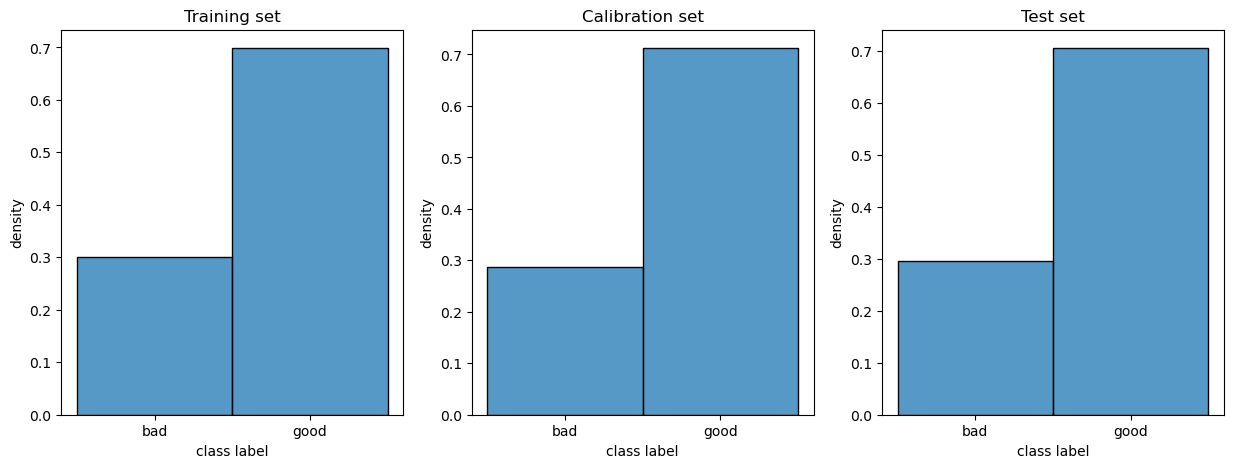

In [6]:
# dataset

dataset_id = 31 # German Credit Data
dataset = openml.datasets.get_dataset(dataset_id)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# handle datatypes
# convert categorical data to numerical
category_columns = X.select_dtypes(include=['category']).columns
label_encoders = {}
for column in category_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])
# convert uint8 to int
uint8_columns = X.select_dtypes(include=['uint8']).columns
for column in uint8_columns:
    X[column] = X[column].astype('int')
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


# standardize the data
scaler = StandardScaler()
X[uint8_columns] = scaler.fit_transform(X[uint8_columns])
X[['credit_amount']] = scaler.fit_transform(X[['credit_amount']])

# display dataset
display(X.head(5))
print("class labels:", label_encoder.classes_)
print("class distribution:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# plot the class distribution in the training set, calibration set and test set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(y_train, bins=np.arange(3)-0.5, stat='density', ax=ax[0])
sns.histplot(y_cal, bins=np.arange(3)-0.5, stat='density', ax=ax[1])
sns.histplot(y_test, bins=np.arange(3)-0.5, stat='density', ax=ax[2])
for i in range(3):
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(label_encoder.classes_)
    ax[i].set_xlabel('class label')
    ax[i].set_ylabel('density')
ax[0].set_title('Training set')
ax[1].set_title('Calibration set')
ax[2].set_title('Test set')
plt.show()

## Model Training and Evaluation

In [8]:
# base model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

##### Nonconformist Library

Coverage: 0.890
Average Set Width: 1.23
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        59
           1       0.87      0.84      0.86       141

    accuracy                           0.80       200
   macro avg       0.76      0.77      0.76       200
weighted avg       0.80      0.80      0.80       200



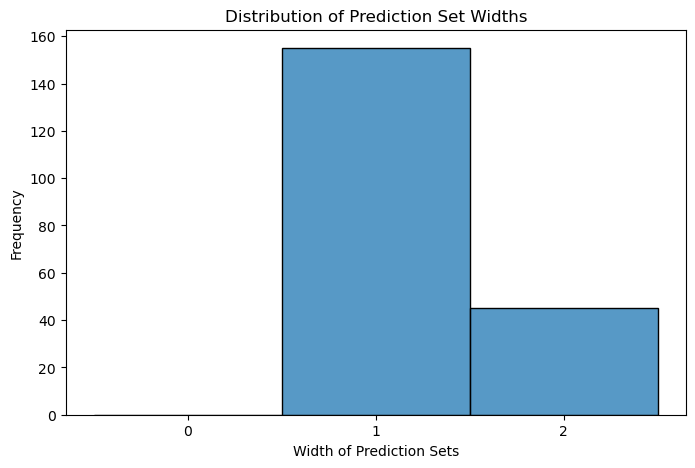

In [9]:
# using Transductive Conformal Prediction
nc = NcFactory.create_nc(clf, err_func=InverseProbabilityErrFunc())
tcp = TcpClassifier(nc)

tcp.fit(X_train, y_train)

predictions = tcp.predict(X_test.values, significance=0.1)

# evaluation
coverage = np.mean([predictions[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in predictions]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.3f}")
print(f"Average Set Width: {average_width:.2f}")
print(classification_report(y_test, [np.argmax(pred) for pred in predictions]))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Crepes Library

Coverage: 0.93
Average Set Width: 1.40
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        59
           1       0.79      0.90      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.66      0.68       200
weighted avg       0.75      0.76      0.74       200



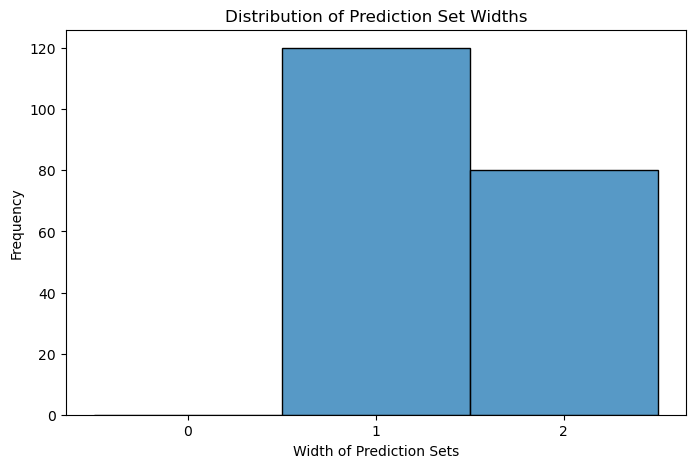

In [11]:
wrapped_clf = WrapClassifier(clf)

wrapped_clf.fit(X_train_proper, y_train_proper)
wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediction_sets)
# print(prediction_sets.shape)


# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

result = wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
# print(result)
print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

Coverage: 0.93
Average Set Width: 1.40
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        59
           1       0.79      0.90      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.66      0.68       200
weighted avg       0.75      0.76      0.74       200



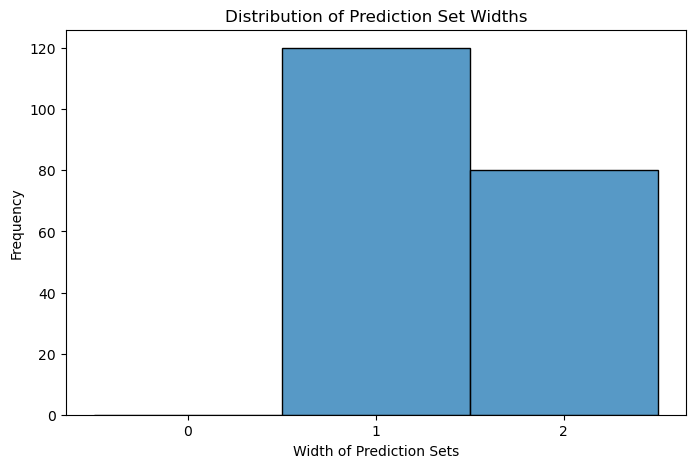

In [54]:
# Mondrian conformal classifiers Class-conditional
wrapped_clf = WrapClassifier(clf)
wrapped_clf.fit(X_train_proper, y_train_proper)

rf_class_cond = WrapClassifier(wrapped_clf.learner)
wrapped_clf = rf_class_cond
wrapped_clf.calibrate(X_cal, y_cal, class_cond=True)

prediciton_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediciton_sets[:5])
# print(prediciton_sets.shape)

# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Venn Abers Library

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        59
           1       0.84      0.81      0.83       141

    accuracy                           0.76       200
   macro avg       0.71      0.73      0.72       200
weighted avg       0.77      0.76      0.76       200



,p0,p1,p of class_1,y
0,0.828571,0.854167,0.832850,0
1,0.400000,0.500000,0.454545,1
2,0.333333,0.400000,0.375000,1
3,0.828571,0.854167,0.832850,1
4,0.833333,0.857143,0.837209,1
5,0.500000,0.750000,0.600000,1
6,0.829787,0.854167,0.833838,1
7,0.481481,0.518519,0.500000,1
8,0.828571,0.854167,0.832850,1
9,0.829787,0.854167,0.833838,1


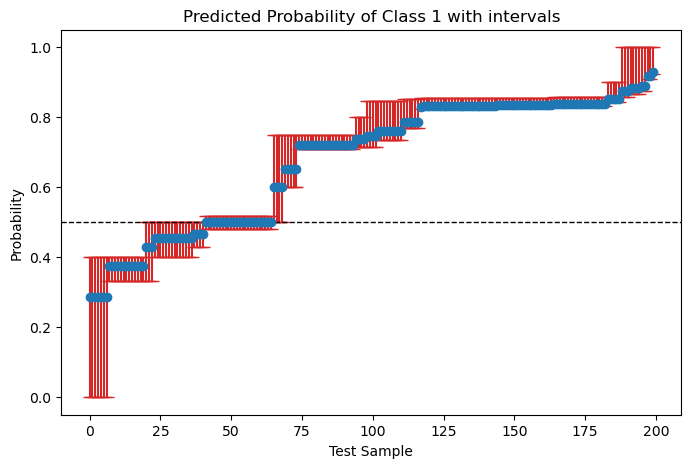

In [50]:
# clf = XGBClassifier(random_state=42)
clf.fit(X_train_proper, y_train_proper)

prediction_prob_cal = clf.predict_proba(X_cal)
prediction_prob_test = clf.predict_proba(X_test)
y_pred_noncal = clf.predict(X_test)

va = VennAbersCalibrator()
p_prime = va.predict_proba(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test, p0_p1_output=True) # probability intervals for class 1
y_pred = va.predict(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test) # predicted class labels

# convert to class labels
y_pred = np.argmax(y_pred, axis=1)

# evaluation
# coverage = np.mean([p_prime[0][i][y_test[i]] <= p_prime[1][i][y_test[i]] for i in range(len(y_test))])
# print(f"Coverage: {coverage:.2f}")
print(classification_report(y_test, y_pred))


# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y': y_test})
display(df.head(10))


# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.47      0.58        59
           1       0.81      0.94      0.87       141

    accuracy                           0.80       200
   macro avg       0.78      0.71      0.73       200
weighted avg       0.79      0.80      0.78       200



,p0,p1,p of class_1,y
0,0.666667,1.000000,0.750000,0
1,-0.000000,1.000000,0.500000,1
2,-0.000000,0.142857,0.125000,1
3,-0.000000,1.000000,0.500000,1
4,0.983607,1.000000,0.983871,1
5,-0.000000,1.000000,0.500000,1
6,0.985294,1.000000,0.985507,1
7,-0.000000,1.000000,0.500000,1
8,0.976744,1.000000,0.977273,1
9,0.800000,1.000000,0.833333,1


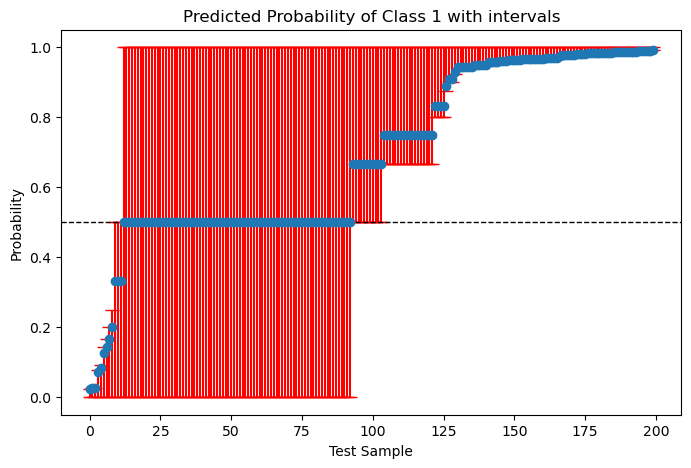

In [53]:
sys.path.append("VennABERS")
import VennABERS

clf.fit(X_train, y_train)
prediction_cls = clf.predict(X_test)

y_pred_calib = clf.predict_proba(X_cal)[:,1]
calibrPts = zip(list(y_pred_calib),list(y_cal))

testScores = clf.predict_proba(X_test)[:,1]
p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,testScores)
p = p1/(1-p0+p1)

print(classification_report(y_test, prediction_cls))

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': p0, 'p1': p1, 'p of class_1': p, 'y': y_test})
display(df.head(10))


# plot predction probabilities for class 1 with intervals
df = df.sort_values(by='p of class_1')
df = df.reset_index(drop=True)
y_pred_p1 = df['p of class_1']
lower_bound = df['p of class_1'] - df['p0']
upper_bound = df['p1'] - df['p of class_1']
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='red', capsize=5)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
plt.show()